In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px


## Problem 1: An Unintuitive Result

The support vector classifier generalizes the optimal separating hyperplane by allowing *slack variables* to handle cases where the points are misclassified (or within the margin).  A somewhat uninuitive result related to the support vector classifier arises when we have a two-class problem where the data is only *barely separable* - a SVC with a small cost that misclassifies a few data points may outperform an optimally separating hyperplane (with no points inside the margin, let alone misclassified) on out-of-sample data.  Let's show this via a simulated example.

### Part 1

`simSVMTrain.csv` contains 729 instances of two predictors and a binary class label.  In this simulated example, the classes are **linearly separable**.  However, they are generated from two separate data generating processes.  As shown in the below figure, the first DGP generates data that is separable with a large margin.  The second DGP generates data that is still linearly separable, but with less of a margin than the first.  This kind of conditional separating behavior is "exaggerated" in this data set, but it does occur quite frequently in real data sets when there is an important omitted predictor that conditions how classes are separated.

```{r, include=TRUE, eval = TRUE}
train <- fread("simSVMTrain.csv")
par(mfrow = c(1,2))
plot(train$X1,train$X2, col = train$class + 3, type = "n", xlab = "X1", ylab = "X2")
points(train$X1[train$class == -1 & train$group == 1],train$X2[train$class == -1 & train$group == 1], pch = "+", col = "blue")
points(train$X1[train$class == 1 & train$group == 1],train$X2[train$class == 1 & train$group == 1], pch = "+", col = "red")
points(train$X1[train$class == -1 & train$group == 2],train$X2[train$class == -1 & train$group == 2], pch = "+", col = "green")
points(train$X1[train$class == 1 & train$group == 2],train$X2[train$class == 1 & train$group == 2], pch = "+", col = "orange")
plot(train$X1,train$X2, col = as.numeric(train$class) + 3, pch = "+", xlab = "X1", ylab = "X2")
par(mfrow = c(1,1))
```

While it may not immediately appear to be the case in the combined data set, the classes are actually linearly separable!  Prove that this is true by 1) plotting the data and corresponding labels, 2) computing the optimal separating hyperplane and corresponding margins and plotting them against the data, and 3) showing that the **signed distance** from the hyperplane multiplied by the class label is greater than or equal to one for all observations in the data set. (Note: When you compute the signed distance, you may find that a few observations have a signed distance of .999---.  This can happen due to a combination of rounding and our approximation to the perfectly separable case with a finite cost.)

Some hints:

  1) We can use SVM software to get the separating hyperplane and margins in the perfectly separable case when we set `cost` to be very high.  `cost = 10000` should be sufficient.
  
  2) There's no need for a nonlinear kernel here since the decision boundary is linear.  Make sure to set the kernel to linear or vanilladot since most SVM software sets the kernel to radial/Gaussian by default.
  
  3) For the two predictor case, the separating hyperplane can be computed by finding all values of $\boldsymbol{x} \in \mathbb{R}^2$ such that $\hat{\alpha} + \hat{\beta}_1 x_1 + \hat{\beta}_2 x_2 = 0$.  Given the coefficients (which can usually be found using `coef()` or a similar argument in R or `svm.decision_function` in `sklearn`) and a value of $x_1$, we can uniquely compute $x_2$ that solves the equation.
  
  4) The predictors are already normalized, so don't worry about that here.
  
  5) Since the SVM coefficients are normalized in the actual computation, we can compute the margins by finding values of $\boldsymbol{x}$ that solve $\hat{\alpha} + \hat{\beta}_1 x_1 + \hat{\beta}_2 x_2 = \pm 1$
  
  6) For most SVM implementations, you can force it to treat any response as a classification problem by ensuring that the method used is *C-classification*.  This means that you don't necessarily convert `y` to a factor in R.  Check your chosen implementation for this option!
  
  7) It is possible that all of the signed distances will be less than or equal to -1!  Because there is no real requirement that the SVC assigns $y = -1$ to be the negative distance class, we could just have everything reversed.  This is equivalent, so don't think that there's something wrong!
  

In [224]:
df_train = pd.read_csv('simSVMTrain.csv')
print(df_train[['class', 'group']].value_counts())
df_train.head(10)

class  group
 1     1        344
-1     1        340
 1     2         29
-1     2         16
dtype: int64


,class,X1,X2,group
0,1,0.754761,-1.392704,1
1,1,0.893396,-1.629868,1
2,1,1.326277,-0.478627,1
3,-1,-0.159908,0.640877,1
4,-1,0.022537,0.711255,1
5,-1,0.778287,1.688937,1
6,-1,-1.619465,-0.197490,1
7,-1,-1.211850,1.328023,1
8,-1,-1.734995,-0.503190,1
9,-1,-0.385711,1.053679,1


Solve for $\boldsymbol{x} \in \mathbb{R}^2$ such that $\hat{\alpha} + \hat{\beta}_1 x_1 + \hat{\beta}_2 x_2 = 0$

In [225]:
from sklearn.svm import SVC
clf = SVC(C=10000, kernel='linear')
clf.fit(X=df_train[['X1', 'X2']], y=df_train['class'])
svm_coefs = [clf.intercept_, clf.coef_[0]]
svm_coefs = [_ for sublist in svm_coefs for _ in sublist]


Text(0.5, 0.98, 'Optimal Linear Separating Hyperplane')

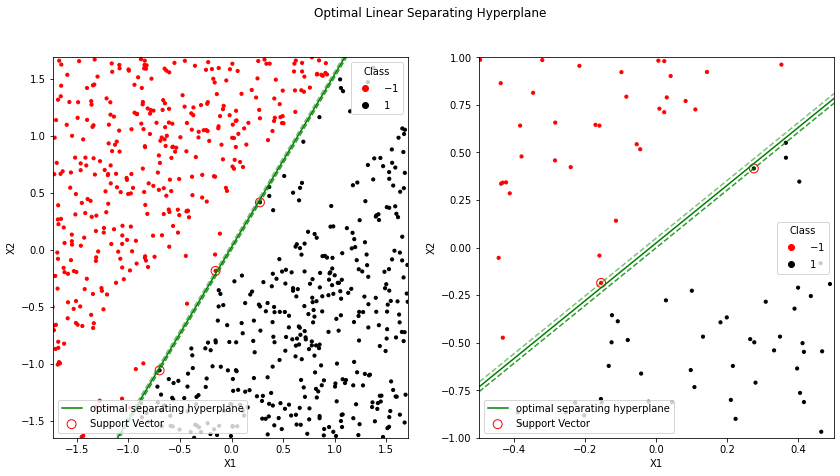

In [226]:
def get_bound(x, h=0):
    return (np.min(x)-h, np.max(x)+h)
def plot_svm_zoom(x, y, coef, xbound: tuple, ybound: tuple, ax: plt.axes, legend=True, **kwargs):
    x1_hyperplane = np.arange(np.min(x['X1']), np.max(x['X1']), 0.02)
    x2_hyperplane = [(-coef[0] - (coef[1] * x1))/coef[2] for x1 in x1_hyperplane] # solve for x2 given coefs
    scatter = ax.scatter(x=x['X1'], y=x['X2'], c=y, cmap=plt.cm.flag, s=10)
    line = ax.plot(x1_hyperplane, x2_hyperplane, 'g-', label='optimal separating hyperplane')

    #margin 
    x2_margin1 = [(1-coef[0] - (coef[1] * x1))/coef[2] for x1 in x1_hyperplane]
    x2_margin2 = [(-1-coef[0] - (coef[1] * x1))/coef[2] for x1 in x1_hyperplane]
    margin1 = ax.plot(x1_hyperplane, x2_margin1, 'g--', alpha= 0.8)
    margin2 = ax.plot(x1_hyperplane, x2_margin2, 'g--', alpha =0.5)

    # support vectors
    if 'support_vectors' in kwargs:
        support_vectors = kwargs['support_vectors']
        ax.scatter(support_vectors[:,0], support_vectors[:, 1], s=80, facecolors='none', edgecolors='r', label='Support Vector')
    if legend:
        ax.add_artist(ax.legend(*scatter.legend_elements(), title='Class'))
        ax.legend(loc='lower left')
    ax.set_xbound(xbound)
    ax.set_ybound(ybound)
    ax.set_xlabel('X1')
    ax.set_ylabel('X2')
    #ax.set_ylim(np.min(df_train['X2'])-0.2, np.max(df_train['X2'])+0.2)

fig, axs = plt.subplots(1, 2, figsize=(14,7))
plot_svm_zoom(df_train[['X1', 'X2']], df_train['class'], svm_coefs, get_bound(df_train['X1']), get_bound(df_train['X2']), axs[0], support_vectors = clf.support_vectors_)
plot_svm_zoom(df_train[['X1', 'X2']], df_train['class'], svm_coefs, (-0.5, 0.5), (-1, 1), axs[1], support_vectors = clf.support_vectors_)
fig.suptitle('Optimal Linear Separating Hyperplane')

In [227]:
# signed distance
def signed_distance(x, beta, alpha):
    assert isinstance(x, np.ndarray) and isinstance(beta, np.ndarray)
    beta_2norm = np.sqrt(np.sum(np.square(beta)))
    return 1/beta_2norm * (beta.T.dot(x)+alpha)

df_train['signed_distance'] = df_train.apply(lambda row: signed_distance(row[['X1', 'X2']].to_numpy(), beta=np.array(svm_coefs[1:3]), alpha=svm_coefs[0]), axis=1)
df_train['signed_distance*class'] = df_train['signed_distance'] * df_train['class']
df_train.sort_values('signed_distance*class')

,class,X1,X2,group,signed_distance,signed_distance*class
706,1,0.274761,0.415829,2,0.013902,0.013902
689,-1,-0.155180,-0.185779,2,-0.013907,0.013907
721,1,-0.697609,-1.059080,2,0.013916,0.013916
725,1,0.365015,0.550566,2,0.015091,0.015091
726,1,-0.877023,-1.346295,2,0.022217,0.022217
...,...,...,...,...,...,...
286,-1,-1.591858,1.535296,1,-2.160692,2.160692
391,1,1.631088,-1.447747,1,2.172039,2.172039
594,1,1.676691,-1.516798,1,2.248120,2.248120
272,-1,-1.650372,1.625260,1,-2.259063,2.259063


In [228]:
# check if theres any mis-classified points
df_train.query('`signed_distance*class` > 0').shape[0] == len(df_train)

True

the number of observations in the df above equals the total number of observations in the test set, meaning that all points are correctly classified, and the training set is linearly separable. 

### Part 2

Now, let's think about out of sample performance.  `simSVMTestF.csv` includes 200 observations that are generated using the same DGP used to generate the training data just with slightly different levels of occurrence for each group (feel free to verify this yourself!).

```{r, include=TRUE, eval = TRUE}
test <- fread("simSVMTestF.csv")
par(mfrow = c(1,2))
plot(train$X1,train$X2, pch = "+", col = as.numeric(train$class) + 3, xlab = "X1", ylab = "X2", main = "Train")
plot(test$X1,test$X2, col = as.numeric(test$class) + 3, pch = "+", xlab = "X1", ylab = "X2", main = "Test")
par(mfrow = c(1,1))
```

Using `cost = 10000`, compute the proportion of observations misclassified in the training set, a 10-fold cross validation measure of the expected proportion of observations misclassified in a test set, and the actual proportion of observations misclassified using the trained SVC to create predictions for the test set.  What do you see from these measures?  How can it be the case that data generated from the exact same process can yield training errors?  Think about the SVC and **overfitting**.

Now repeat this process for 250 different values of `cost` ranging from very small to very large - a reasonable set of cost values can be generated using `exp(seq(-10,10,length = 250))` in R.   Make a plot that shows the training error, 10 fold CV estimate, and actual proportion of misclassified points in the test set plotted against the cost values.

There's a decent amount of information to unpack from this graph!  

  1) What value of cost returns the lowest proportion of misclassified points in the test set?  How does this cost value compare to the optimal separating hyperplane with minimal slackness?  Provide some reasoning for this result.
  
  2) Does the K-fold CV error estimate more closely correspond to the training error or the test error?  In a few sentences, provide some reasoning for this result.  Think very carefully about how cross validation would work for the SVC and why we might see this relationship - how does drawing the decision boundary for **supprt vector** classification differ from the other models we've discussed in class?
  
Note that your findings for this problem are most prevalent when the data are perfectly separable and this relationship tends to disappear as there is more crossover between classes.  This may seem like the most common scenario, but an SVM using the radial kernel is **guaranteed* to perfectly separate any training data in the two class problem so long as there are no two points with the same $\boldsymbol x_i$ that have different classes!  Just something to be wary of and why a combined $K$-fold and validation set approach is preferable to just using $K$-fold cross validation!


In [229]:
# 10-fold cv
from sklearn.model_selection import cross_val_score
clf = SVC(C=10000, kernel='linear')
print(
f"""
Based on 10-fold cv, the expected misclassified proportion in the test set: 
{np.mean(1-cross_val_score(estimator=clf, X=df_train[['X1', 'X2']], y=df_train['class'], cv=10))}
""".replace('\n',''))

Based on 10-fold cv, the expected misclassified proportion in the test set: 0.03333333333333334


In [230]:
# test set
df_test = pd.read_csv('simSVMTestF.csv')
clf.fit(X=df_train[['X1', 'X2']], y=df_train['class'])
svm_coefs = [clf.intercept_, clf.coef_[0]]
svm_coefs = [_ for sublist in svm_coefs for _ in sublist]

1-clf.score(X=df_test[['X1', 'X2']], y=df_test['class'])

0.05500000000000005

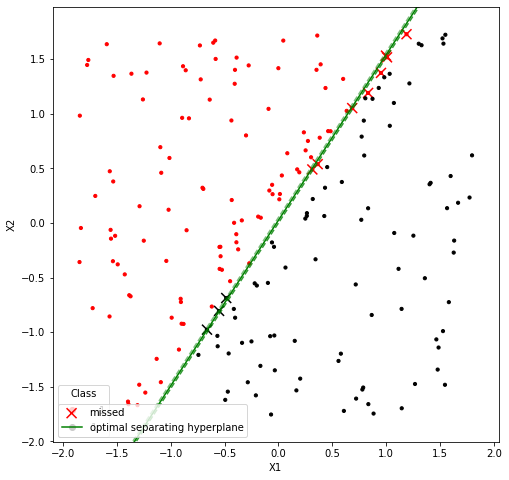

In [231]:
df_pred = df_test.copy()
df_pred['pred_class'] = clf.predict(X=df_test[['X1', 'X2']])
df_pred_wrong = df_pred.query('`pred_class` != `class`')

fig, ax = plt.subplots(figsize=(8,8))
ax.scatter(x=df_pred_wrong['X1'], y=df_pred_wrong['X2'], marker='x', c=df_pred_wrong['class'], cmap=plt.cm.flag, s=100, label='missed')
plot_svm_zoom(x=df_test[['X1', 'X2']], y=df_test['class'], coef=svm_coefs, xbound=get_bound(df_test['X1'],0.25), ybound=get_bound(df_test['X2'],0.25), ax=ax)


In [160]:
df_pred_wrong

,X1,X2,class,group,pred_class
14,0.998408,1.532650,-1,1,1
19,-0.484156,-0.687662,1,2,-1
40,0.832488,1.190832,-1,2,1
44,-0.662777,-0.977537,1,2,-1
62,0.951933,1.374308,-1,2,1
67,0.314899,0.490072,-1,2,1
99,-0.550690,-0.805748,1,2,-1
150,1.188931,1.728782,-1,1,1
155,0.364638,0.538504,-1,2,1
183,0.685064,1.051987,-1,2,1


In [232]:
from sklearn.model_selection import cross_val_score

costs = np.exp(np.linspace(-10, 10, 250))
clfs = [SVC(C=cost, kernel='linear') for cost in costs]
cv10_miss_prop = [np.mean(1-cross_val_score(estimator=clf, X=df_train[['X1', 'X2']], y=df_train['class'], cv=20)) for clf in clfs]

[clf.fit(X=df_train[['X1', 'X2']], y=df_train['class']) for clf in clfs]
train_miss_prop = [1-clf.score(df_train[['X1', 'X2']], df_train[['class']]) for clf in clfs]
test_miss_prop = [1-clf.score(df_test[['X1', 'X2']], df_test[['class']]) for clf in clfs]

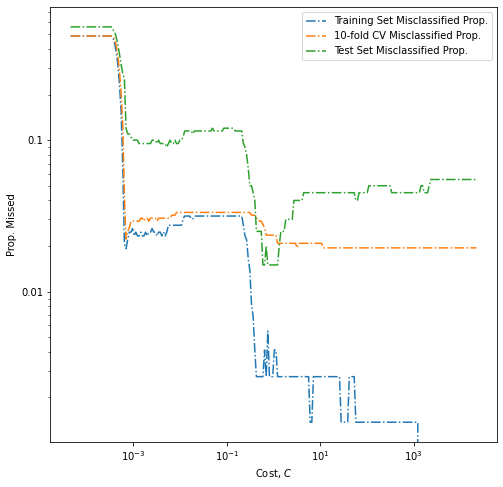

In [234]:
import matplotlib.ticker as ticker
svc_cost_df = pd.DataFrame(
    {
     'cost': costs,
     'train_miss_prop': train_miss_prop,
     'cv10_miss_prop': cv10_miss_prop,
     'test_miss_prop': test_miss_prop
    }
)
svc_cost_df

fig, ax = plt.subplots(figsize = (8,8))
ax.plot(svc_cost_df['cost'], svc_cost_df['train_miss_prop'], '-.', label='Training Set Misclassified Prop.')
ax.plot(svc_cost_df['cost'], svc_cost_df['cv10_miss_prop'], '-.', label='10-fold CV Misclassified Prop.')
ax.plot(svc_cost_df['cost'], svc_cost_df['test_miss_prop'], '-.', label='Test Set Misclassified Prop.')
#ax.set_xscale('log')
ax.loglog()
ax.legend()
ax.set_xlabel('Cost, $C$')
ax.set_ylabel('Prop. Missed')
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: '{:g}'.format(y))) # y-tickers to decimal

In [238]:
# where does training set's missclassfication rate meets 0
svc_cost_df.query("`train_miss_prop` == 0").sort_values('cost', ascending=True).head(5)

,cost,train_miss_prop,cv10_miss_prop,test_miss_prop
214,1324.453261,0.0,0.019444,0.045
215,1435.224132,0.0,0.019444,0.050
216,1555.259342,0.0,0.019444,0.050
217,1685.333718,0.0,0.019444,0.045
218,1826.286886,0.0,0.019444,0.045


In the training set, with $C\geq1324.4$, the labels in the training set were perfectly classified. This makes sense because we have seen from (1) that the training set is linearly separable. After $C$ has passed the threshold, higher $C$ would not affect the coefs of the separating hyperplane because the objective function is already minimized.

In [242]:
svc_cost_df.sort_values(['test_miss_prop', 'cost']).head(10)

,cost,train_miss_prop,cv10_miss_prop,test_miss_prop
118,0.593280,0.002743,0.027778,0.015
119,0.642899,0.004115,0.026389,0.015
121,0.754934,0.005487,0.023611,0.015
122,0.818073,0.002743,0.023611,0.015
123,0.886493,0.002743,0.023611,0.015
124,0.960635,0.002743,0.023611,0.015
125,1.040978,0.004115,0.023611,0.015
126,1.128040,0.004115,0.023611,0.015
127,1.222384,0.002743,0.020833,0.015
120,0.696668,0.002743,0.023611,0.020


The test set misclassification rate is first minimized at $C=0.59328$, then the err starts to climb back up again. However, this result does not agree with our results from k-fold validation, which, based on our plot above, suggests that error would be minimized for $C>10$. I think this happens because of the different levels of occurrence for each group in training and test set. Because SVM is very sensitive to the data near the separating hyperplane or the decision boundary and the margins are dependent upon the support vectors, test set has a denser data distribution near the hyperplane and this difference could therefore result in the problem mentioned above. If we had used monte carlo cross validation or assigned class weight, the performance demonstrated by cv could be more representable to the test set.

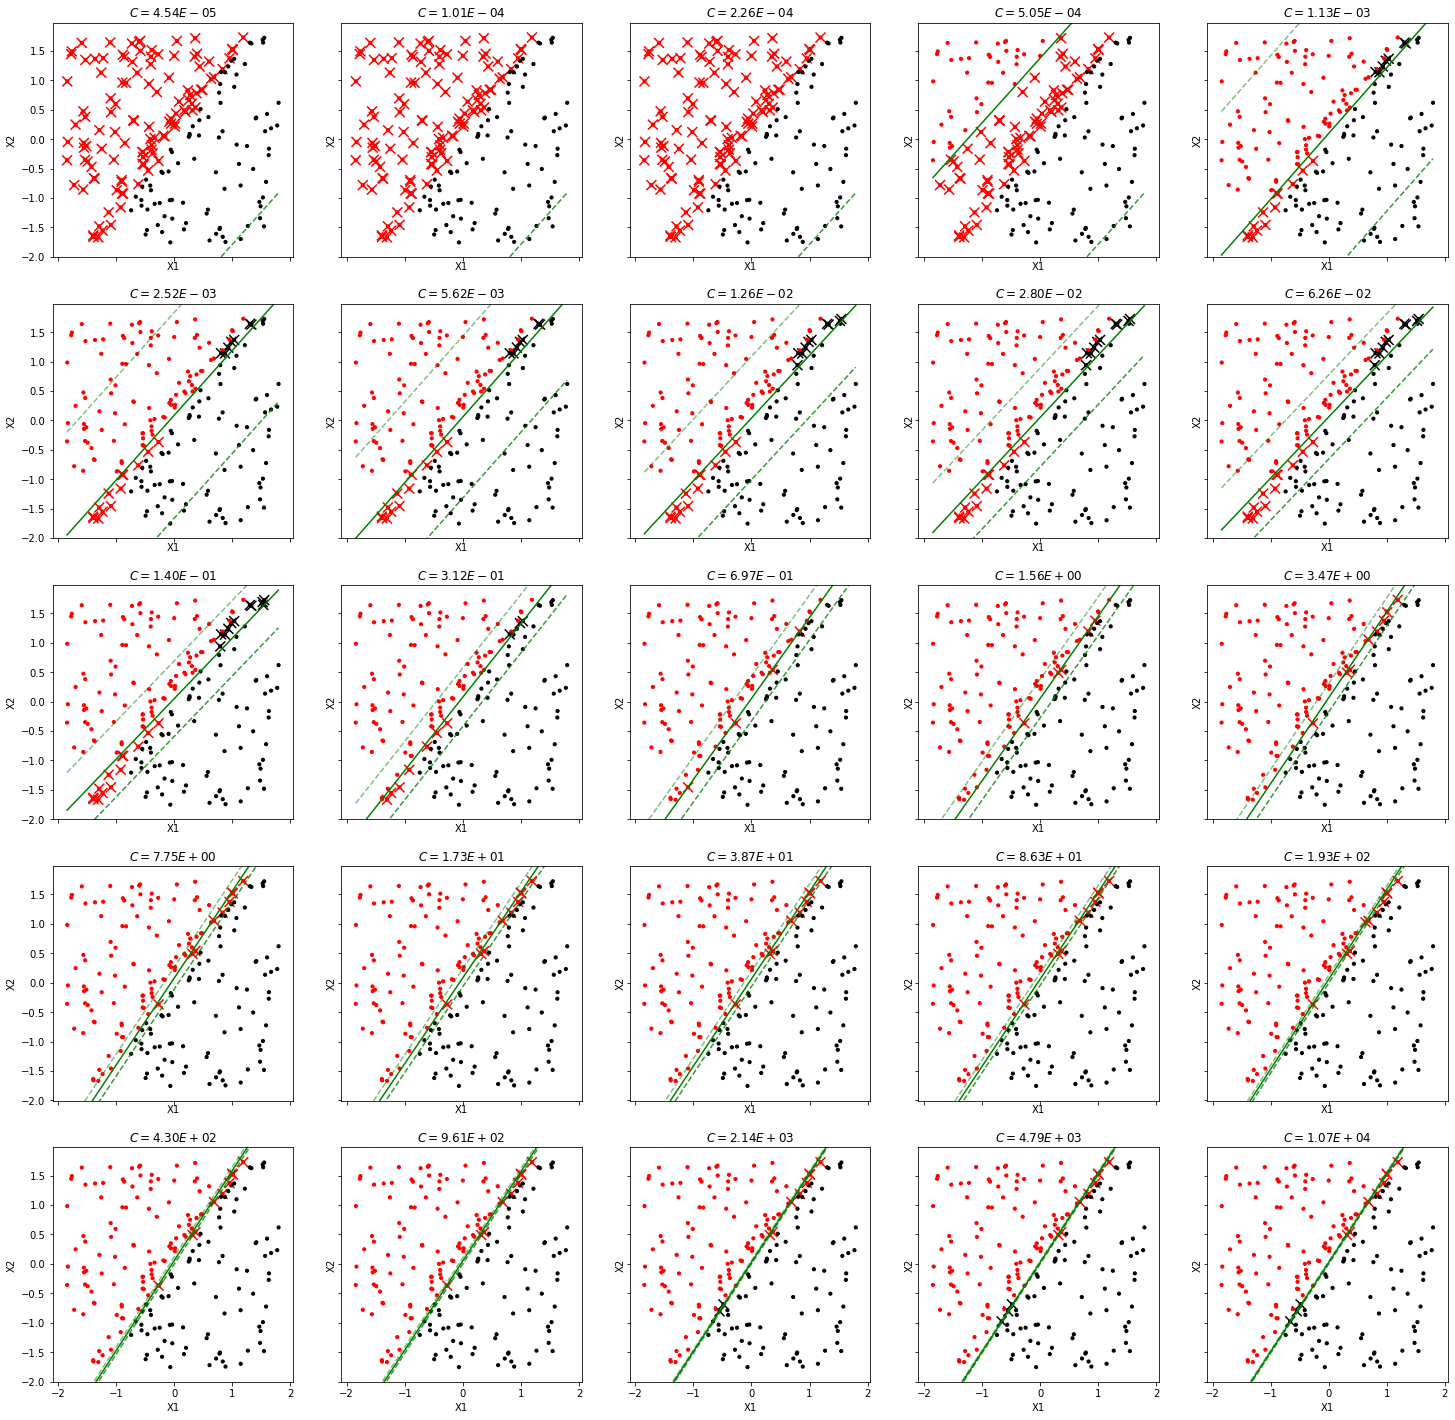

In [239]:
fig, axs = plt.subplots(5,5,figsize=(25,25), sharex=True, sharey=True)
for ax, clf in zip(axs.flatten(), [clf for i, clf in enumerate(clfs) if i%10==0]):
    # misses
    df_pred = df_test.copy()
    df_pred['pred_class'] = clf.predict(X=df_test[['X1', 'X2']])
    df_pred_wrong = df_pred.query('`pred_class` != `class`')
    ax.scatter(x=df_pred_wrong['X1'], y=df_pred_wrong['X2'], marker='x', c=df_pred_wrong['class'], cmap=plt.cm.flag, s=100, label='missed')
    
    svm_coefs = [clf.intercept_, clf.coef_[0]]
    svm_coefs = [_ for sublist in svm_coefs for _ in sublist]
    plot_svm_zoom(x=df_test[['X1', 'X2']], y=df_test['class'], coef=svm_coefs, xbound=get_bound(df_test['X1'],0.25), ybound=get_bound(df_test['X2'],0.25), ax=ax, legend=False)#, support_vectors=clf.support_vectors_)
    ax.set_title(f"$C = {clf.C:.2E}$")

Based on the characteristics of SVM, probably Monte Carlo Cross Validation could be (?) more appropriate because same data points can be resampled in different folds.


## Problem 2: Some Data on Cars

The data set `carsTrain.csv` contains data related to the overall fuel performance for a variety of cars.  The main outcome variable is `mpg` - this is coded as 1 if the car gets greater than 20 miles per gallon and is coded as 0 for all other MPGs.  There are 8 predictors with the country of origin being a set of two dummy coded variables indicating whether the car was produced in the U.S. or Europe.  The variable for Japanese cars was dropped from the data set as a base category.

There is also a test set, `carsTest.csv`, that contains 92 observations that can be used to quantify out-of-sample predictive ability.

Using all available predictors, compute classification models for the `mpg` variable using the training data and compare them in terms of out of sample predictive ability.  Use the following classification approaches:

  1) Logistic regression
  2) QDA
  3) Logistic GAM (you don't need to worry about selecting spline interactions unless you really want to)
  4) Logistic LASSO
  5) Support Vector Classifier w/ Linear Separator
  6) Support Vector Machine w/ Polynomial Kernel
  7) Support Vector Machine w/ Radial Kernel
  
For some approaches, there are tuning parameters.  Use cross validation approaches to select these tuning parameters and settle on a single final model.

For each classification approach, use your final model to compute 1) the training misclassification rate, 2) a 10-fold CV estimate of the misclassification rate for out of sample data, and 3) the misclassification rate for the held out test set.  When appropriate, use the Bayes' classifier to convert probability to a class label.  Create a table that summarizes your results.

Which method performs the best?  Worst?  Provide some intuition for this result.

Some notes:

  1) For the Logistic GAM, remember that splines for binary and categorical variables make little sense.  Be careful with `cylinders`, in particular.
  
  2) GCV doesn't make much sense for logistic regression models.  This is particularly relevant for GAMs, which are optimizing to a specific likelihood.  Rather than using this measure, just compute the 10-fold estimate of misclassification rate for the Logistic GAM.
  
  3) If using built in K-fold approaches, make sure that the measure being used to choose a model is the misclassification rate.  In `glmnet`, `type.measure` allows you to change the measure that is estimated via cross validation.
  
  4) For support vector methods, always tune `cost` using cross validation.  For polynomial kernels, there is an additional parameter - `degree`.  This is similar to the degree of a spline.  Realistically, we only care about positive integers for this value (though we could consider other values).  For the radial kernel, the `gamma` parameter controls the spread of the resulting Gaussian kernelization.  This value need only be greater than zero, so try a range of values and zoom in on one that minimizes the CV error.


In [19]:
df_car_train = pd.read_csv('carsTrain.csv')
df_car_test = pd.read_csv('carsTest.csv')

df_car_train_X = df_car_train.drop('mpg', axis=1)
df_car_train_y = df_car_train['mpg']
df_car_test_X = df_car_test.drop('mpg', axis=1)
df_car_test_y = df_car_test['mpg']


df_car_train.head(10)


,mpg,cylinders,displacement,horsepower,weight,acceleration,year,american,european
0,0,8,307.0,130,3504,12.0,70,1,0
1,0,8,350.0,165,3693,11.5,70,1,0
2,0,8,318.0,150,3436,11.0,70,1,0
3,0,8,304.0,150,3433,12.0,70,1,0
4,0,8,429.0,198,4341,10.0,70,1,0
5,0,8,454.0,220,4354,9.0,70,1,0
6,0,8,455.0,225,4425,10.0,70,1,0
7,0,8,390.0,190,3850,8.5,70,1,0
8,0,8,383.0,170,3563,10.0,70,1,0
9,0,8,340.0,160,3609,8.0,70,1,0


In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

def plot_confusion_matrix(pred_y, true_y, title='Confusion Matrix'):
    if not isinstance(true_y, np.ndarray):
        #print('c')
        true_y = true_y.to_numpy()

    classes_ = np.unique(pred_y)
    length_ = pred_y.shape[0]
    num_correct = np.sum(np.equal(pred_y, true_y))
    num_false = length_ - num_correct

    num_correct_class0 = np.column_stack([true_y, pred_y])[np.equal(true_y, pred_y) & (true_y == 0)].shape[0]
    num_correct_class1 = np.column_stack([true_y, pred_y])[np.equal(true_y, pred_y) & (true_y == 1)].shape[0]
    num_false_class0 = true_y[true_y == 0].shape[0] - num_correct_class0
    num_false_class1 = true_y[true_y == 1].shape[0] - num_correct_class1
    #print(classes_, type(classes_[0]))

    ## construct confusion matrix
    confusion_matrix_count = pd.DataFrame(columns=[classes_[0], classes_[1]], index=[classes_[0], classes_[1]])
    confusion_matrix_count.loc[classes_[0], classes_[0]] = num_correct_class0
    confusion_matrix_count.loc[classes_[0], classes_[1]] = num_false_class0
    confusion_matrix_count.loc[classes_[1], classes_[0]] = num_false_class1
    confusion_matrix_count.loc[classes_[1], classes_[1]] = num_correct_class1
    #print(confusion_matrix_count)
    confusion_matrix_count = confusion_matrix_count.astype(int)
    
    confusion_matrix_prop = confusion_matrix_count / confusion_matrix_count.sum(axis=0)

    fig, ax = plt.subplots(1,2,figsize=(10, 6))
    confusion_matrix = [confusion_matrix_count, confusion_matrix_prop]
    for ax, confusion_matrix in zip(ax, confusion_matrix):
        ax.matshow(confusion_matrix, cmap=plt.cm.coolwarm)
        ax.set_xlabel('Predicted Class')
        ax.set_ylabel('True Class')
        ax.set_title('Confusion Matrix')
        ax.set_xticks(np.arange(2))
        ax.set_yticks(np.arange(2))
        ax.set_xticklabels([classes_[0], classes_[1]])
        ax.set_yticklabels([classes_[0], classes_[1]], rotation=90)

        ax.text(0, 0, np.round(confusion_matrix.loc[classes_[0], classes_[0]], 2), ha='center', va='center', color='white', fontsize=12)
        ax.text(0, 1, np.round(confusion_matrix.loc[classes_[0], classes_[1]], 2), ha='center', va='center', color='white', fontsize=12)
        ax.text(1, 0, np.round(confusion_matrix.loc[classes_[1], classes_[0]], 2), ha='center', va='center', color='white', fontsize=12)
        ax.text(1, 1, np.round(confusion_matrix.loc[classes_[1], classes_[1]], 2), ha='center', va='center', color='white', fontsize=12)

        cbar = ax.figure.colorbar(ax.images[0], ax=ax, location='bottom', fraction=0.1, pad=0.1)

        ax.set_aspect('equal')
        ax.grid(False)

    fig.suptitle(title)

In [17]:
import warnings
import itertools
from sklearn.model_selection import cross_val_score

def report_accuracy(clf, warning=False):
    with warnings.catch_warnings():
        if not warning:
            warnings.simplefilter("ignore")
        print(
f"""Misclassification Rate on: 
1. Training Set: {1-clf.score(df_car_train_X, df_car_train_y)}
2. 10-fold CV: {1 - np.mean(cross_val_score(estimator=clf, X=df_car_train_X, y=df_car_train_y, cv=10))}
3. Test Set: {1-clf.score(df_car_test_X, df_car_test_y)}
"""
        )

def get_minMax(var):
    min = np.min(df_car_train[var].unique())
    max = np.max(df_car_train[var].unique())
    return (min, max)

def report_lookup_table(clf, var_1, var_2, max_table_length=10, warnings=False, roundUp=True):
    predictors = list(df_car_train_X.columns)
    assert var_1 in predictors and var_2 in predictors
    
    var_1_levels = df_car_train[var_1].unique() if len(df_car_train[var_1].unique()) <= 10 else np.linspace(*get_minMax(var_1), max_table_length)
    var_2_levels = df_car_train[var_2].unique() if len(df_car_train[var_2].unique()) <= 10 else np.linspace(*get_minMax(var_2), max_table_length)
    
    if roundUp:
        var_1_levels = np.round(var_1_levels)
        var_2_levels = np.round(var_2_levels)

    lookup_table_df = pd.DataFrame(
        columns = [var_1, var_2, 'prob_class_1']
    )
    clf.fit(df_car_train[[var_1, var_2]])
    print(df_car_train[var_1].unique())
    print(df_car_train[var_2].unique())
    print(var_1_levels)
    print(var_2_levels)

### Logistic Regression

In [199]:
from sklearn.linear_model import LogisticRegression

logistic_reg = LogisticRegression(solver='newton-cg', penalty='none', max_iter=10000)
logistic_reg.fit(X=df_car_train_X, y=df_car_train_y)


1-logistic_reg.score(df_car_test_X, df_car_test_y)

0.07608695652173914

Misclassification Rate on: 
1. Training Set: 0.08333333333333337
2. 10-fold CV: 0.10666666666666669
3. Test Set: 0.07608695652173914



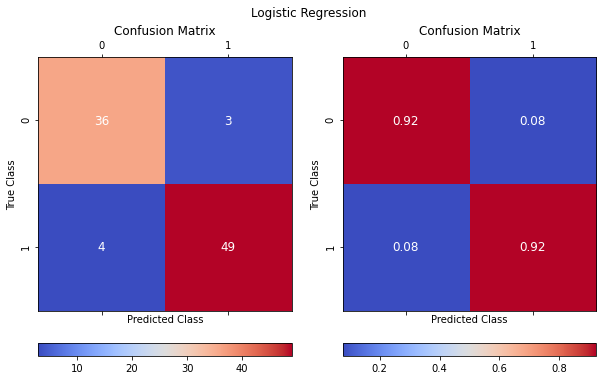

In [198]:
report_accuracy(logistic_reg)
plot_confusion_matrix(logistic_reg.predict(df_car_test_X), df_car_test_y, 'Logistic Regression')

### QDA

Misclassification Rate on: 
1. Training Set: 0.08666666666666667
2. 10-fold CV: 0.09999999999999998
3. Test Set: 0.06521739130434778



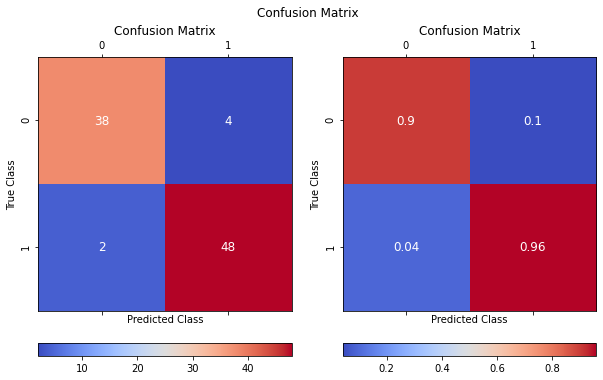

In [182]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

qda_clf = QuadraticDiscriminantAnalysis()
qda_clf.fit(X=df_car_train_X, y=df_car_train_y)

report_accuracy(clf=qda_clf, warning=False)
plot_confusion_matrix(qda_clf.predict(df_car_test_X), df_car_test_y)

### Logistic GAMs

In [183]:
from pygam import l, s, f, te, LogisticGAM

def getGamTerms():
    for i in range(0, len(df_car_train_X.columns)):
        if i == 0: # initialize the first gam term
            gam_terms = s(0) if len(df_car_train_X.iloc[:,0].unique()) > 10 else f(0)
            continue
        # check if categorical
        if len(df_car_train_X.iloc[:,i].unique()) <= 10: #fewer than 10 levels
            gam_terms += f(i) # use factor term
        else:
            gam_terms += s(i)
    return gam_terms

gam_clf = LogisticGAM(terms=getGamTerms(), max_iter=10000)
gam_clf.fit(X=df_car_train_X, y=df_car_train_y)
gam_clf.summary()

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                     22.9459
Link Function:                        LogitLink Log Likelihood:                                   -37.0636
Number of Samples:                          300 AIC:                                               120.019
                                                AICc:                                             124.3625
                                                UBRE:                                               2.4613
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.8125
Feature Function                  Lam

/var/folders/vw/fhlnd7k958g99z5bj0yg57vh0000gn/T/ipykernel_78139/236432529.py:17: UserWarning:

KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 




Misclassification Rate on: 
1. Training Set: 0.050000000000000044
2. 10-fold CV: 0.09333333333333316
3. Test Set: 0.07608695652173914



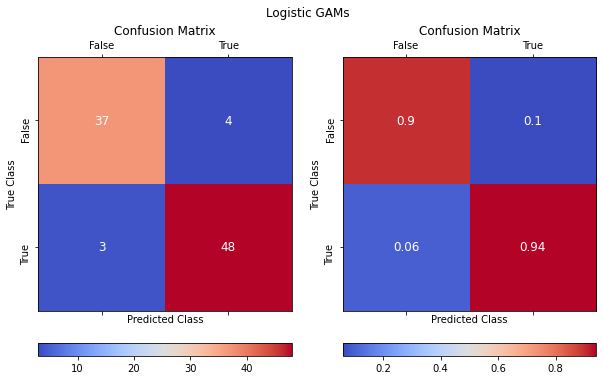

In [185]:
def get_accuracy(y_true, y_pred):
    return np.sum(np.equal(y_true, y_pred))/len(y_true)

def kfold(x_train, y_train, folds, seed):

    train_full = np.column_stack((x_train, y_train))
    np.random.seed(seed)
    np.random.shuffle(train_full)
    x_train = train_full[:, :-1]
    y_train = train_full[:, -1]

    scores = []

    foldSize = int(len(x_train) / folds)
    if folds == 1:
        return
    for i in range(folds):
        x_train_cv = np.delete(x_train, range(i * foldSize, (i + 1) * foldSize), axis=0)
        y_train_cv = np.delete(y_train, range(i * foldSize, (i + 1) * foldSize), axis=0)
        clf = LogisticGAM(terms=getGamTerms(), max_iter=10000) # generalize later if were to use more frequen.
        clf.fit(x_train_cv, y_train_cv)
        y_pred = clf.predict(x_train[i * foldSize: (i + 1) * foldSize])
        scores.append(get_accuracy(y_true=y_train[i * foldSize: (i + 1) * foldSize], y_pred=y_pred))
    
    return np.mean(scores)

print(
f"""Misclassification Rate on: 
1. Training Set: {1-get_accuracy(gam_clf.predict(df_car_train_X), df_car_train_y)}
2. 10-fold CV: {1 - kfold(df_car_train_X.to_numpy(), df_car_train_y.to_numpy(), 10, 123)}
3. Test Set: {1-get_accuracy(gam_clf.predict(df_car_test_X), df_car_test_y)}
"""
)
plot_confusion_matrix(gam_clf.predict(df_car_test_X), df_car_test_y, 'Logistic GAMs')


### Logistic LASSO

requires tuning on regularization parameter $\lambda$

In [93]:
from sklearn.model_selection import GridSearchCV

# find \lambda

logit_lasso_gridsearch = GridSearchCV(LogisticRegression(penalty='l1', solver='liblinear', max_iter=10000),
                    param_grid={
                        'C': np.exp(np.linspace(-10, 10, 250)) # Cost parameter C, inverse of regularization strength. (1/lambda)
                    }, cv=30, verbose=0, n_jobs=-1
                    )
logit_lasso_gridsearch.fit(df_car_train_X, df_car_train_y)

GridSearchCV(cv=30,
             estimator=LogisticRegression(max_iter=10000, penalty='l1',
                                          solver='liblinear'),
             n_jobs=-1,
             param_grid={'C': array([4.53999298e-05, 4.91969605e-05, 5.33115565e-05, 5.77702775e-05,
       6.26019043e-05, 6.78376251e-05, 7.35112363e-05, 7.96593608e-05,
       8.63216848e-05, 9.35412134e-05, 1.01364548e-04, 1.09842189e-04,
       1.19028859e-04, 1.28983858e-04, 1.39771445e...
       2.95711045e+03, 3.20442888e+03, 3.47243183e+03, 3.76284924e+03,
       4.07755577e+03, 4.41858283e+03, 4.78813175e+03, 5.18858795e+03,
       5.62253637e+03, 6.09277814e+03, 6.60234866e+03, 7.15453720e+03,
       7.75290812e+03, 8.40132389e+03, 9.10397002e+03, 9.86538208e+03,
       1.06904750e+04, 1.15845746e+04, 1.25534525e+04, 1.36033626e+04,
       1.47410821e+04, 1.59739550e+04, 1.73099394e+04, 1.87576590e+04,
       2.03264590e+04, 2.20264658e+04])})

In [55]:
logit_lasso_gridsearch.cv_results_.keys()

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_C', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'split5_test_score', 'split6_test_score', 'split7_test_score', 'split8_test_score', 'split9_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score'])

Text(0.5, 0.98, 'Logistic Lasso Grid Search, cv=10')

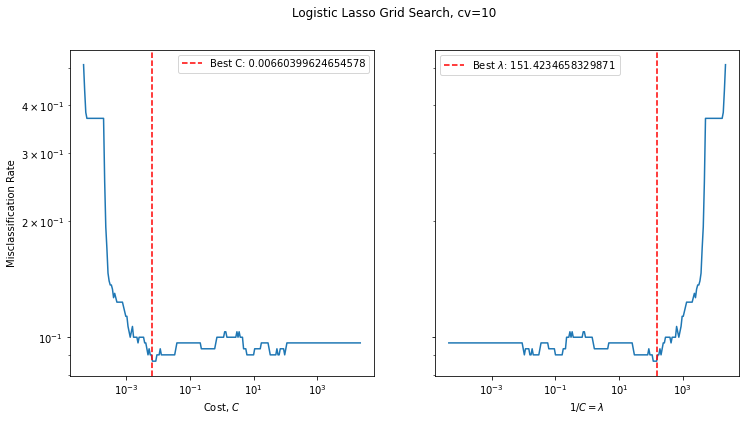

In [97]:
import matplotlib.ticker as ticker
fig, ax = plt.subplots(1,2, figsize=(12, 6), sharey=True)
ax[0].plot(np.exp(np.linspace(-10, 10, 250)), 1-logit_lasso_gridsearch.cv_results_['mean_test_score'], '-')
ax[1].plot(1/np.exp(np.linspace(-10, 10, 250)), 1-logit_lasso_gridsearch.cv_results_['mean_test_score'], '-')
ax[0].set_xlabel('Cost, $C$')
ax[0].set_ylabel('Misclassification Rate')
ax[1].set_xlabel('$1/C=\lambda$')
ax[0].axvline(logit_lasso_gridsearch.best_params_['C'], color='r', linestyle='--', label=f"Best C: {logit_lasso_gridsearch.best_params_['C']}")
ax[1].axvline(1/logit_lasso_gridsearch.best_params_['C'], color='r', linestyle='--', label=f"Best $\lambda$: {1/logit_lasso_gridsearch.best_params_['C']}")
ax[0].loglog()
ax[1].loglog()
ax[0].legend()
ax[1].legend()
fig.suptitle('Logistic Lasso Grid Search, cv=10')

Misclassification Rate on: 
1. Training Set: 0.08333333333333337
2. 10-fold CV: 0.09333333333333338
3. Test Set: 0.06521739130434778



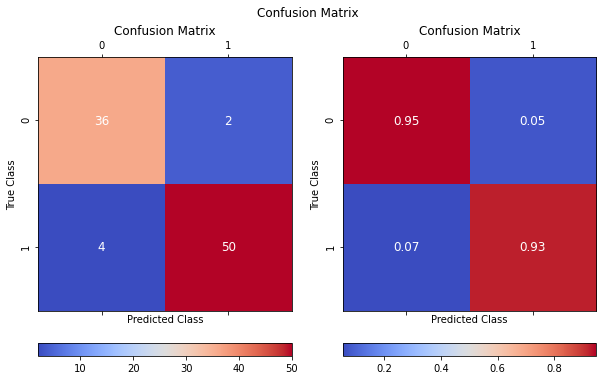

In [95]:
logistic_lasso = LogisticRegression(penalty='l1', solver='liblinear', C=logit_lasso_gridsearch.best_params_['C'], max_iter=10000)
logistic_lasso.fit(X=df_car_train_X, y=df_car_train_y)
report_accuracy(logistic_lasso)
plot_confusion_matrix(logistic_lasso.predict(df_car_test_X), df_car_test_y)

### SVM (Linear Hyperplane)

In [ ]:
from sklearn.svm import SVC

# find C - Cost
svm_linear_gridsearch = GridSearchCV(SVC(kernel='linear'), param_grid={
                        'C': np.exp(np.linspace(-10, 10, 250))
                    }, cv=10, verbose=0, n_jobs=-1
                    )
svm_linear_gridsearch.fit(df_car_train_X, df_car_train_y)



Text(0.5, 0.98, 'SVM Linear, Grid Search, cv=10')

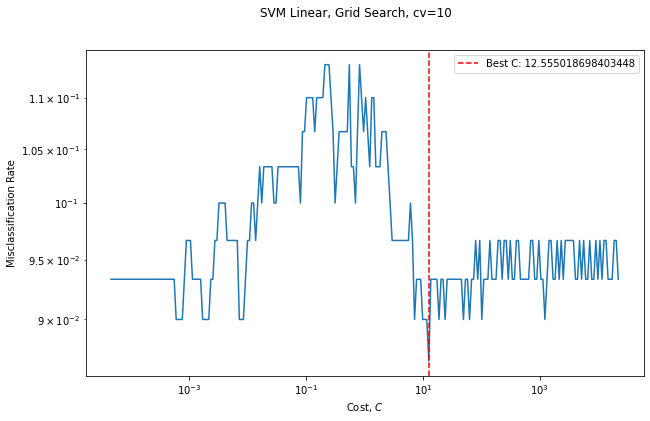

In [105]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(np.exp(np.linspace(-10, 10, 250)), 1-svm_linear_gridsearch.cv_results_['mean_test_score'], '-')
ax.set_xlabel('Cost, $C$')
ax.set_ylabel('Misclassification Rate')
ax.axvline(svm_linear_gridsearch.best_params_['C'], color='r', linestyle='--', label=f"Best C: {svm_linear_gridsearch.best_params_['C']}")
ax.loglog()
ax.legend()
fig.suptitle('SVM Linear, Grid Search, cv=10')

The mean test error across the folds is a bit odd-looking, but we still choose the $C$ denoted by the red line, because it's the first dip right after the bell-shaped error curve.

Misclassification Rate on: 
1. Training Set: 0.08999999999999997
2. 10-fold CV: 0.08666666666666656
3. Test Set: 0.07608695652173914



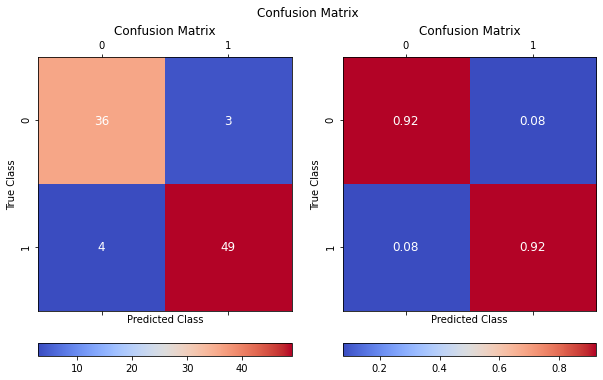

In [107]:
svc_linear = SVC(C=svm_linear_gridsearch.best_params_['C'], kernel='linear')
svc_linear.fit(X=df_car_train_X, y=df_car_train_y)
report_accuracy(svc_linear)
plot_confusion_matrix(svc_linear.predict(df_car_test_X), df_car_test_y)

### SVM (Polynomial Kernel)

In [108]:
svc_poly_gridsearch = GridSearchCV(SVC(kernel='poly'), param_grid={
                        'C': np.exp(np.linspace(-10, 10, 250)),
                        'degree': [2, 3, 4, 5, 6, 7, 8, 9, 10]  # Degree of the polynomial kernel function (‘poly’).
                    }, cv=10, verbose=0, n_jobs=-1
                    )
svc_poly_gridsearch.fit(df_car_train_X, df_car_train_y)

GridSearchCV(cv=10, estimator=SVC(kernel='poly'), n_jobs=-1,
             param_grid={'C': array([4.53999298e-05, 4.91969605e-05, 5.33115565e-05, 5.77702775e-05,
       6.26019043e-05, 6.78376251e-05, 7.35112363e-05, 7.96593608e-05,
       8.63216848e-05, 9.35412134e-05, 1.01364548e-04, 1.09842189e-04,
       1.19028859e-04, 1.28983858e-04, 1.39771445e-04, 1.51461253e-04,
       1.64128740e-04, 1.77855675e-04...
       4.07755577e+03, 4.41858283e+03, 4.78813175e+03, 5.18858795e+03,
       5.62253637e+03, 6.09277814e+03, 6.60234866e+03, 7.15453720e+03,
       7.75290812e+03, 8.40132389e+03, 9.10397002e+03, 9.86538208e+03,
       1.06904750e+04, 1.15845746e+04, 1.25534525e+04, 1.36033626e+04,
       1.47410821e+04, 1.59739550e+04, 1.73099394e+04, 1.87576590e+04,
       2.03264590e+04, 2.20264658e+04]),
                         'degree': [2, 3, 4, 5, 6, 7, 8, 9, 10]})

Text(0.5, 0.98, 'SVM Polynomial, Grid Search, cv=10')

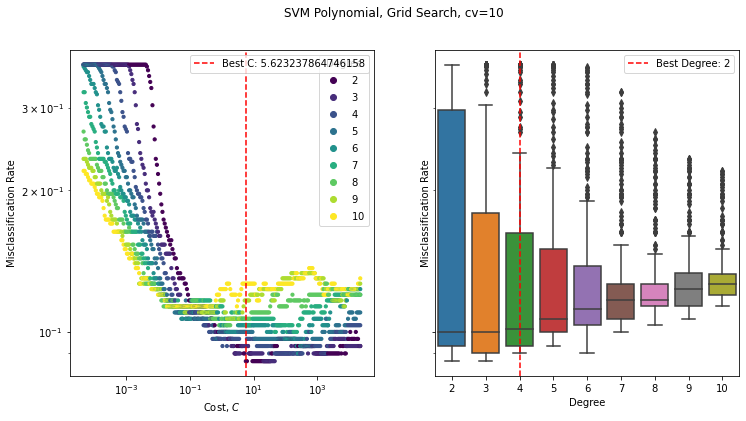

In [132]:
df_results_cv = pd.DataFrame(svc_poly_gridsearch.cv_results_)
df_results_cv = df_results_cv[df_results_cv.columns[df_results_cv.columns.str.startswith('param_') | df_results_cv.columns.str.startswith('mean_test_score')]]
df_results_cv.columns = ['C', 'degree', 'mean_test_score']
df_results_cv['mean_test_score'] = 1-df_results_cv['mean_test_score']
fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharey=True)
scatter = axs[0].scatter(df_results_cv['C'], df_results_cv['mean_test_score'], s=10, c=df_results_cv['degree'], cmap='viridis')
axs[0].set_xlabel('Cost, $C$')
axs[0].set_ylabel('Misclassification Rate')
axs[0].axvline(svc_poly_gridsearch.best_params_['C'], color='r', linestyle='--', label=f"Best C: {svc_poly_gridsearch.best_params_['C']}")
axs[0].loglog()

axs[0].add_artist(axs[0].legend(*scatter.legend_elements(), title='Degree'))
axs[0].legend()
sns.boxplot(x='degree', y='mean_test_score', data=df_results_cv, ax=axs[1])
axs[1].set_xlabel('Degree')
axs[1].set_ylabel('Misclassification Rate')
axs[1].axvline(svc_poly_gridsearch.best_params_['degree'], color='r', linestyle='--', label=f"Best Degree: {svc_poly_gridsearch.best_params_['degree']}")
axs[1].set_yscale('log')
axs[1].legend()
fig.suptitle('SVM Polynomial, Grid Search, cv=10')



Misclassification Rate on: 
1. Training Set: 0.08999999999999997
2. 10-fold CV: 0.08666666666666667
3. Test Set: 0.08695652173913049



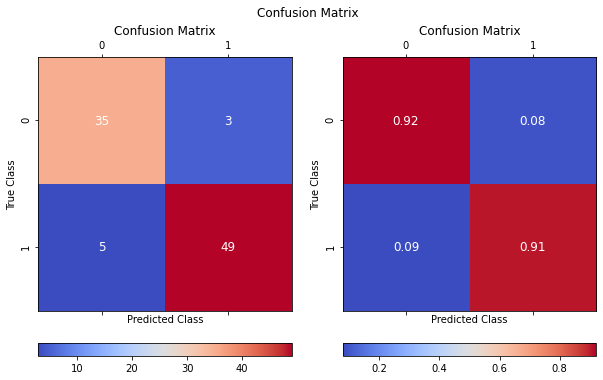

In [133]:
svc_poly = SVC(kernel='poly', C=svc_poly_gridsearch.best_params_['C'], degree=svc_poly_gridsearch.best_params_['degree'])
svc_poly.fit(X=df_car_train_X, y=df_car_train_y)
report_accuracy(svc_poly)
plot_confusion_matrix(svc_poly.predict(df_car_test_X), df_car_test_y)

### SVM (Radial Kernel)

In [163]:
# find C - Cost and gamma - Kernel Coefficient
svc_rbf_gridsearch = GridSearchCV(SVC(kernel='rbf'), param_grid={
                        'C': np.exp(np.linspace(-10, 20, 100)),
                        'gamma': np.exp(np.linspace(-30, 1, 100))
                    }, cv=10, verbose=1, n_jobs=-1
                    )
svc_rbf_gridsearch.fit(df_car_train_X, df_car_train_y)


Fitting 10 folds for each of 10000 candidates, totalling 100000 fits


GridSearchCV(cv=10, estimator=SVC(), n_jobs=-1,
             param_grid={'C': array([4.53999298e-05, 6.14694843e-05, 8.32269459e-05, 1.12685581e-04,
       1.52571261e-04, 2.06574696e-04, 2.79692945e-04, 3.78691799e-04,
       5.12731841e-04, 6.94216093e-04, 9.39937692e-04, 1.27263380e-03,
       1.72308953e-03, 2.33298653e-03, 3.15875992e-03, 4.27682035e-03,
       5.79062440e-03, 7.84024772e-03, 1.06153465e-...
       2.02533491e-03, 2.77005282e-03, 3.78860434e-03, 5.18167839e-03,
       7.08698731e-03, 9.69288046e-03, 1.32569634e-02, 1.81315637e-02,
       2.47985599e-02, 3.39170180e-02, 4.63883434e-02, 6.34453891e-02,
       8.67743295e-02, 1.18681347e-01, 1.62320611e-01, 2.22006081e-01,
       3.03637965e-01, 4.15285984e-01, 5.67987103e-01, 7.76836596e-01,
       1.06248028e+00, 1.45315546e+00, 1.98748235e+00, 2.71828183e+00])},
             verbose=1)

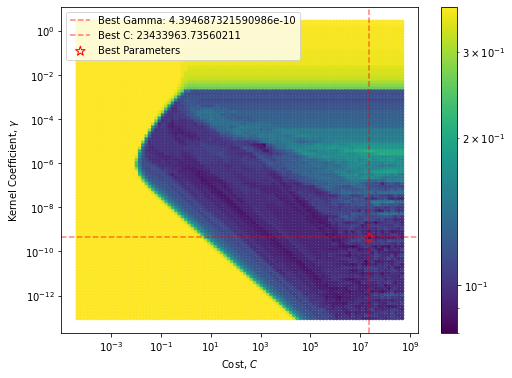

In [177]:
import matplotlib
df_results_cv = pd.DataFrame(svc_rbf_gridsearch.cv_results_)
df_results_cv.to_feather('df_results_cv_rbf.feather')
df_results_cv = df_results_cv[df_results_cv.columns[df_results_cv.columns.str.startswith('param_') | df_results_cv.columns.str.startswith('mean_test_score')]]
df_results_cv.columns = ['C', 'gamma', 'mean_test_score']
df_results_cv['mean_test_score'] = 1-df_results_cv['mean_test_score']

fig, ax = plt.subplots(figsize=(8, 6))
scatter = ax.scatter(df_results_cv['C'], df_results_cv['gamma'], s=10, c=df_results_cv['mean_test_score'], cmap='viridis', norm=matplotlib.colors.LogNorm())
ax.axhline(svc_rbf_gridsearch.best_params_['gamma'], color='r', linestyle='--', label=f"Best Gamma: {svc_rbf_gridsearch.best_params_['gamma']}", alpha=0.5)
ax.axvline(svc_rbf_gridsearch.best_params_['C'], color='r', linestyle='--', label=f"Best C: {svc_rbf_gridsearch.best_params_['C']}", alpha=0.5)
ax.scatter(svc_rbf_gridsearch.best_params_['C'], svc_rbf_gridsearch.best_params_['gamma'], s=100, label='Best Parameters', facecolors='none', edgecolors='r', marker='*')
ax.set_xlabel('Cost, $C$')
ax.set_ylabel('Kernel Coefficient, $\gamma$')
ax.loglog()
fig.colorbar(scatter, ax=ax)
ax.legend()


Misclassification Rate on: 
1. Training Set: 0.07333333333333336
2. 10-fold CV: 0.08000000000000007
3. Test Set: 0.07608695652173914



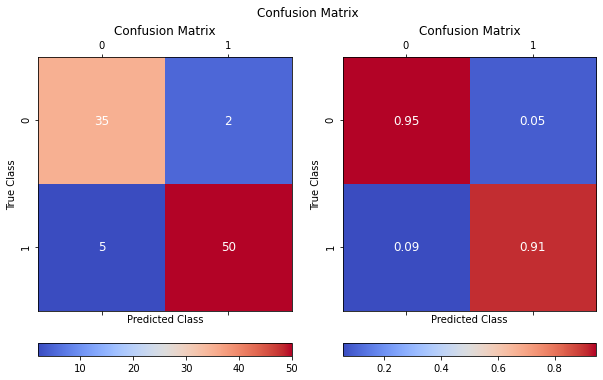

In [171]:
svc_radial = SVC(kernel='rbf', C=svc_rbf_gridsearch.best_params_['C'], gamma=svc_rbf_gridsearch.best_params_['gamma'])
svc_radial.fit(X=df_car_train_X, y=df_car_train_y)
report_accuracy(svc_radial)
plot_confusion_matrix(svc_radial.predict(df_car_test_X), df_car_test_y)

### Summary

In [202]:
svc_poly.__class__ == SVC

True

In [ ]:
opt_clfs = [qda_clf, logistic_reg, gam_clf, logistic_lasso, svc_linear, svc_poly, svc_radial]
opt_clfs_names = ['Logistic Regression', 'Gamma', 'Logistic Lasso', 'Linear SVC', 'Polynomial SVC', 'Radial SVC']
summary_df = pd.DataFrame(
    columns=['Classifier', 'train_miss_rate', 'cv_miss_rate', 'test_miss_rate']
)

for clf in opt_clfs:
    if clf.__class__ == LogisticGAM:
        summary_df.loc[len(summary_df)] = [clf.__class__.__name__,
                                             1-get_accuracy(gam_clf.predict(df_car_train_X), df_car_train_y),
                                                1 - kfold(df_car_train_X.to_numpy(), df_car_train_y.to_numpy(), 10, 123),
                                                1-get_accuracy(gam_clf.predict(df_car_test_X), df_car_test_y)]
    else:
        clf_name = clf.__class__.__name__
        if clf.__class__ == SVC:
            clf_name = str(clf.__class__.__name__) +"_"+ clf.get_params()['kernel']
        elif clf.__class__ == LogisticRegression:
            clf_name = str(clf.__class__.__name__) +"_"+ clf.get_params()['penalty']
        summary_df.loc[len(summary_df)] = [clf_name,
                                             1-clf.score(df_car_train_X, df_car_train_y),
                                                1 - np.mean(cross_val_score(estimator=clf, X=df_car_train_X, y=df_car_train_y, cv=10)),
                                                1-clf.score(df_car_test_X, df_car_test_y)]
                                        

In [220]:
summary_df.style.background_gradient(cmap='coolwarm', axis=0)

,Classifier,train_miss_rate,cv_miss_rate,test_miss_rate
0,QuadraticDiscriminantAnalysis,0.086667,0.100000,0.065217
1,LogisticRegression_none,0.083333,0.106667,0.076087
2,LogisticGAM,0.050000,0.093333,0.076087
3,LogisticRegression_l1,0.083333,0.093333,0.065217
4,SVC_linear,0.090000,0.086667,0.076087
5,SVC_poly,0.090000,0.086667,0.086957
6,SVC_rbf,0.073333,0.080000,0.076087


QDA and Logistic LASSO performs the best on the test set. To me, I am a little surprised how QDA performs better than most of the other methods because it does not require any tuning. Because we have multiple covariates and the decision boundaries are therefore difficult to visualize, it's relatively hard to interpret results from the table above. However, I believe this comparison of methods is very contingent on the data itself and we might see different results for different data sets.